異常検知にはいろいろアプローチがある.

・ 距離に基づくアプローチ
・ 統計学に基づくアプローチ
・ 機械学習に基づくアプローチ

まず，統計学に基づくアプローチを行う．

これは統計的異常検知と呼ばれ,データがある確率分布モデルから生成されていると仮定する.
この方法はデータから得られた情報を,確率モデルという形で表現していると取れる．

-----------------------------------------

統計的異常検知は3ステップからなる
1. 観測データからデータ生成の確率モデルを生成する
    ・未知パラメータを含む確率分布を仮定
    ・データから未知パラメータを推定
2. 生成したモデルを基に,データの異常度あいをスコアリング
3. 闘値の決定

-----------------------------------------

今回扱うデータはFPで求められた,50個のFPGAのデータ．
うち2個は,意図的に経年劣化させたものである．

まずはこのデータをsns.distplotで可視化する．

distplotはx軸はデータの値,y軸はその密度を示す．

In [1]:
import pandas as pd
import generate_nnr_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from statistics import mean, variance
from scipy import stats

In [2]:
def csv_to_data(directory, data_n):
    data = []
    
    for i in range(3, data_n+1):
        tmp_data = pd.read_csv(directory+'/s'+str(i)+'.csv', header=None).values
        data.append(tmp_data)
    
    return np.array(data)


def csv_to_aged_data(directory, aged_data_n):
    aged_data = []

    for i in range(1, aged_data_n+1):
        tmp_data = pd.read_csv(directory+'/s'+str(i)+'_aged.csv', header=None).values
        aged_data.append(tmp_data)
        
    return np.array(aged_data)


def generate_data(directory, data_n, aged_data_n):
    data = csv_to_data(directory, data_n)
    aged_data = csv_to_aged_data(directory, aged_data_n)
    
    return data, aged_data


def generate_residual_data(data_n, data):
    """
    測定値-推定値(周りの平均)
    残差を求めてデータ生成
    """
    tmp_x = [0, 1, 0, -1]
    tmp_y = [-1, 0, 1, 0]

    residual_data = np.zeros_like(data)

    for i in range(data_n):
        for j in range(data[i].shape[0]):
            for k in range(data[i].shape[1]):
                data_list = []
                for l in range(4):
                    next_y = j + tmp_y[l]
                    next_x = k + tmp_x[l]
                    if 0 <= next_y < 148 and 0 <= next_x < 33:
                        data_list.append(data[i, next_y, next_x])

                data_mean = mean(data_list)
                residual_data[i, j, k] = data[i, j, k] - data_mean

    return residual_data


def generate_nnr(data_n=50, aged_data_n=2):
    """
    残差集合のデータ生成
    """
    data, aged_data = generate_data('fresh_aged_ieice', data_n, aged_data_n)

    residual_data = generate_residual_data(data_n-2, data)
    aged_residual_data = generate_residual_data(aged_data_n, aged_data)

    return residual_data, aged_residual_data

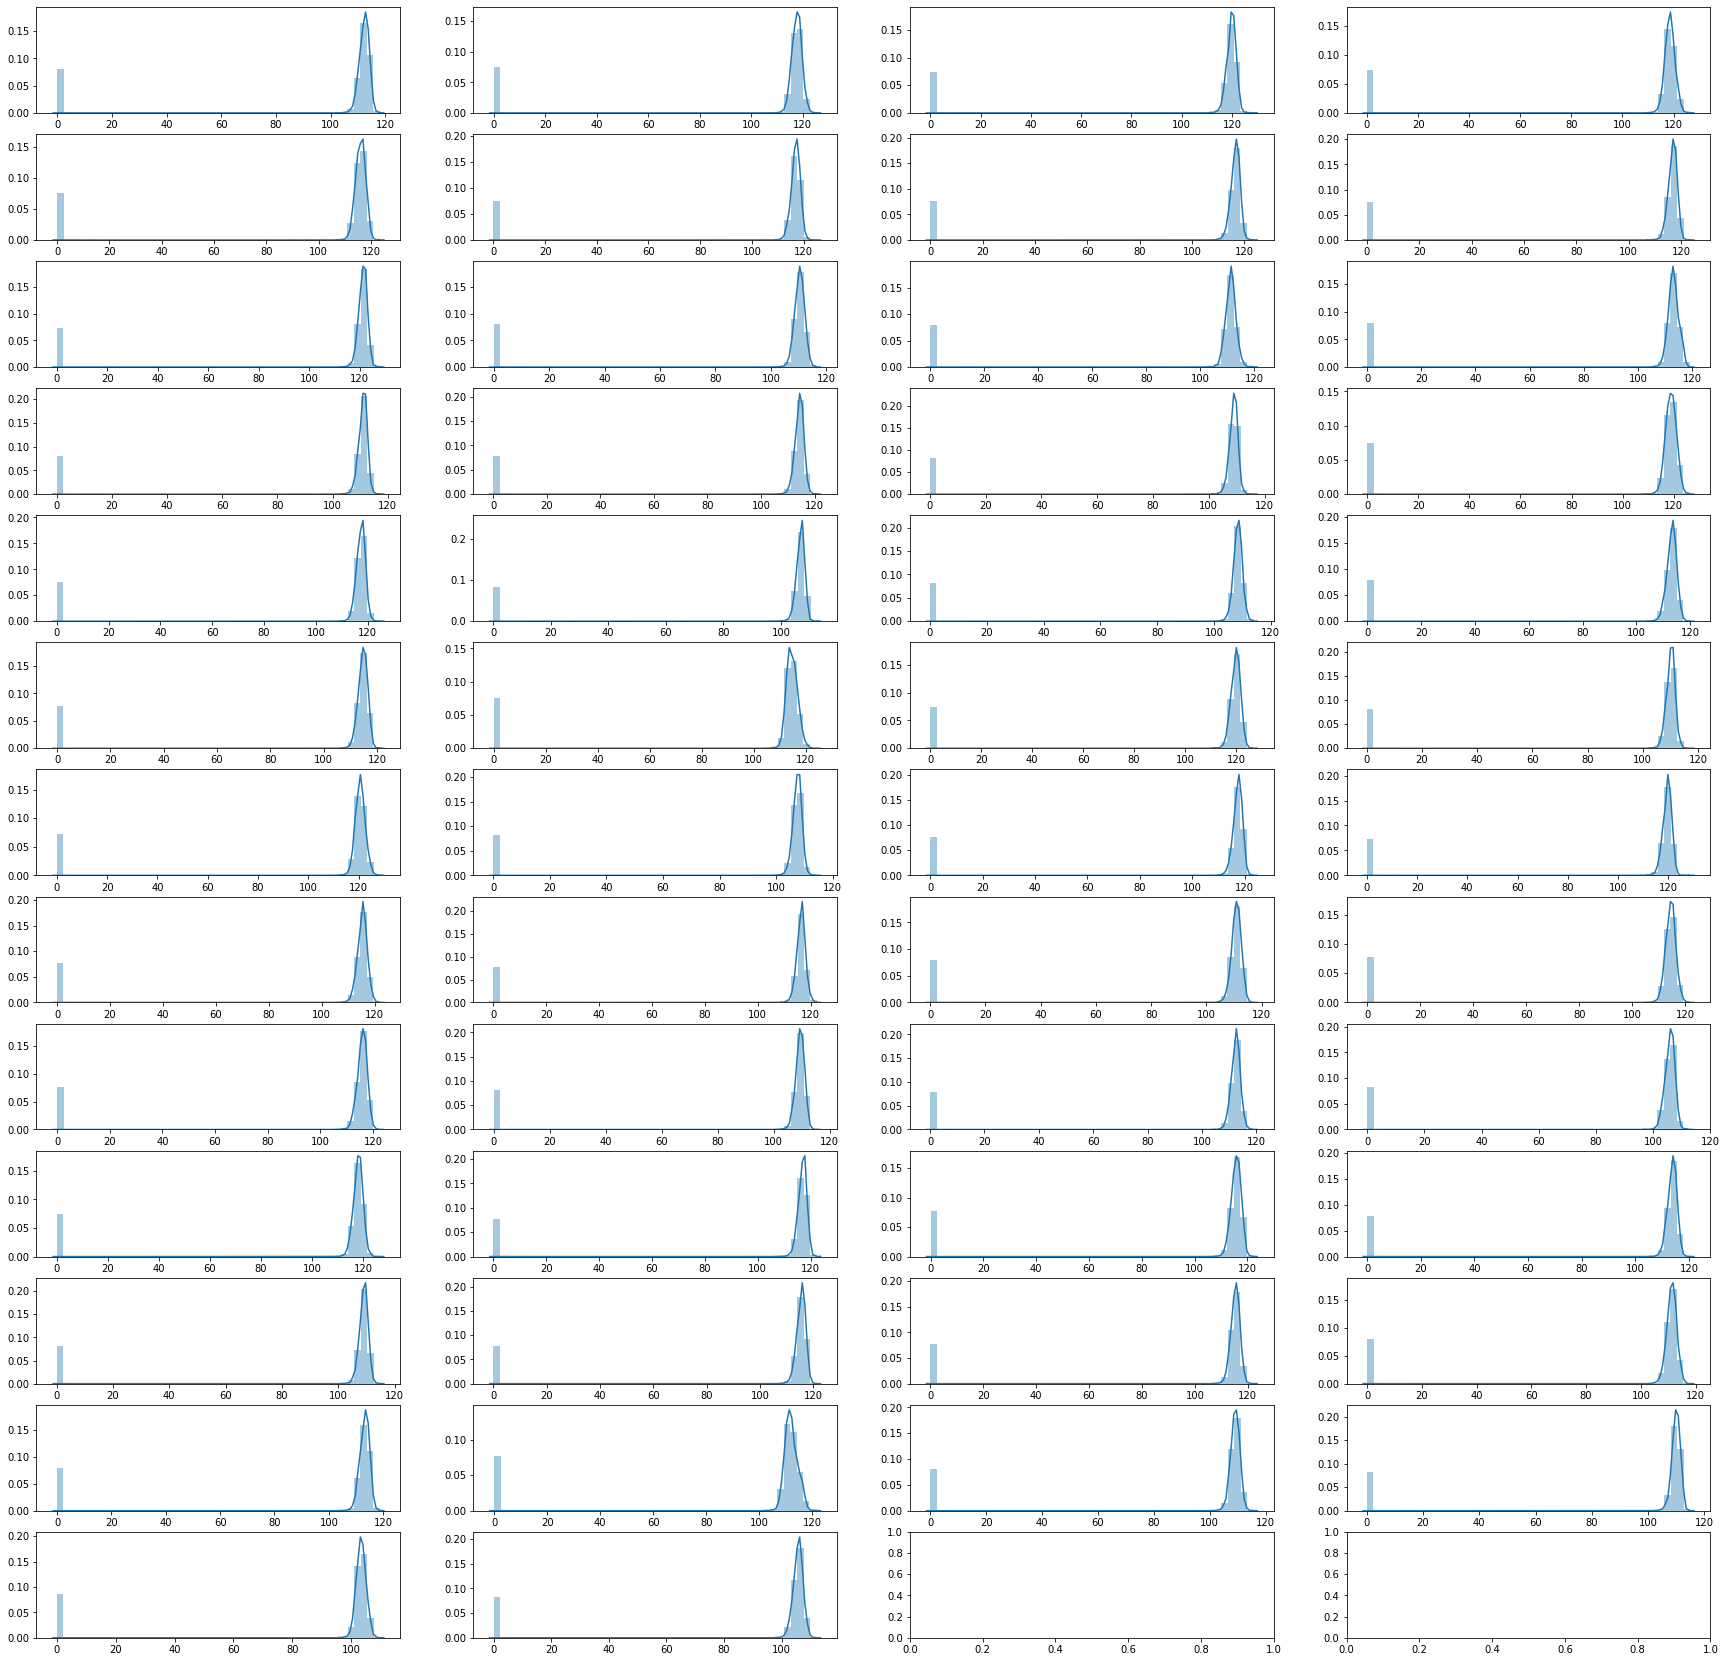

In [3]:
a, b = generate_data('fresh_aged_ieice', 50, 2)

data = []
for i in range(48):
    data.append(a[i].flatten())
    
for i in range(2):
    data.append(b[i].flatten())
    
data = np.array(data)

y = 13
x = 4
fig,ax = plt.subplots(y,x,figsize=(30,30))
count = 0
for i in range(y):
    for j in range(x):
        if count >= 50:
            break
        dummy = sns.distplot(data[count], ax=ax[i, j])
        count += 1
    if count >= 50:
        break

plt.show()

データをみると,0のデータと100付近のデータに散らばっているのがわかる．(最後の二つが経年劣化したもの)

次にデータをいじり,残差データを作りだす．

ここでは,ある測定値を決め,その上下左右の測定値の平均を推定値とし,測定値-推定値の値をそれぞれの測定値に関して求めた．

測定値 - 推定値(上下左右の平均)

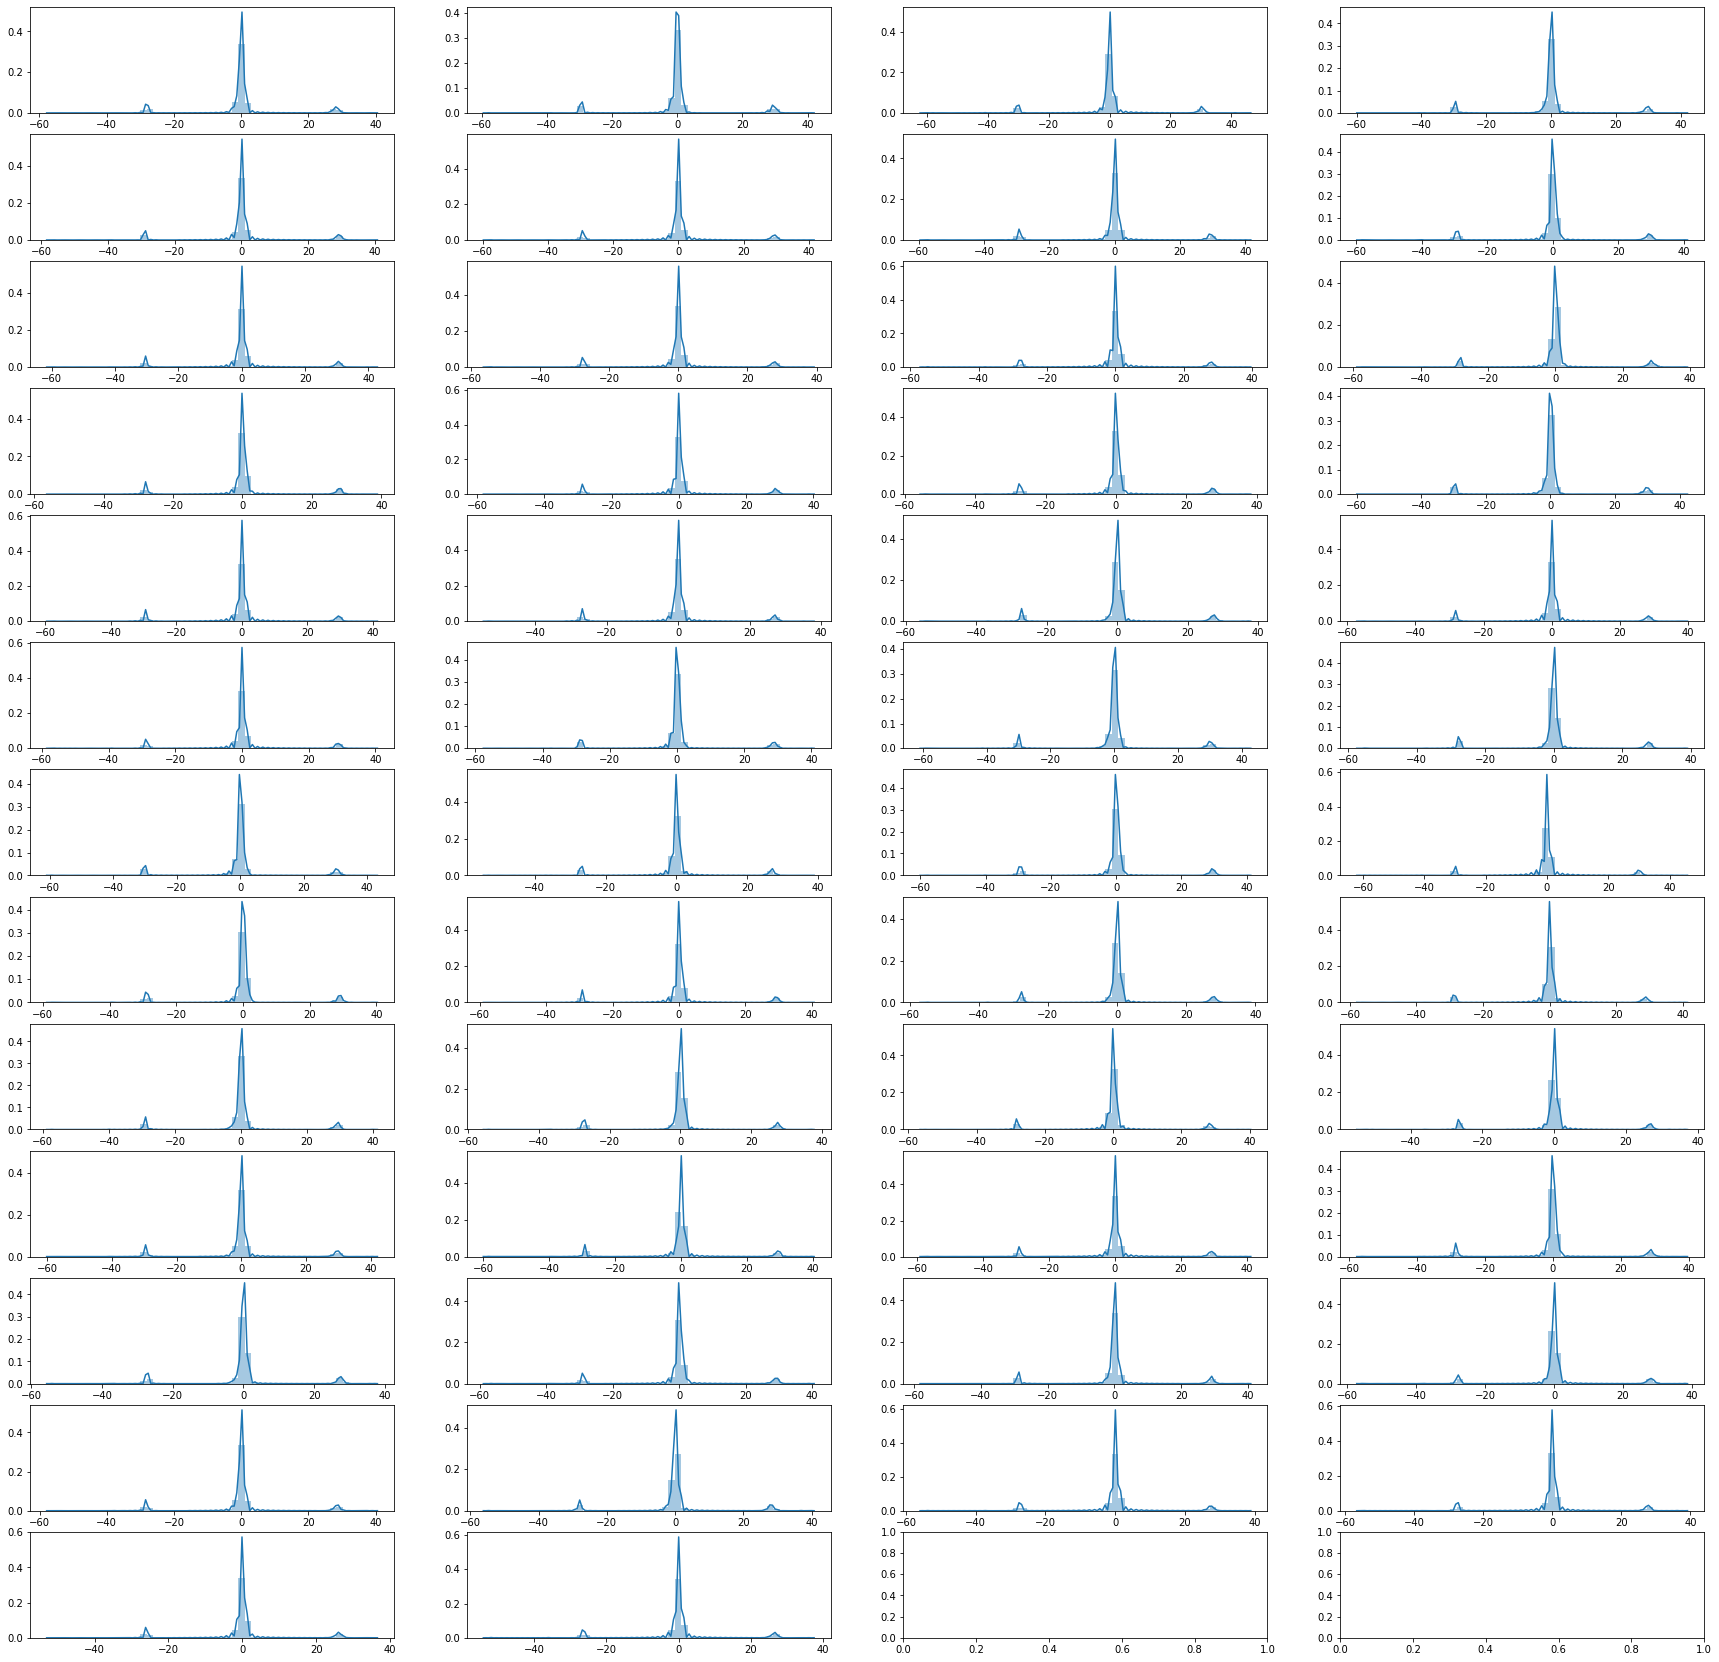

In [4]:
residual_data, aged_residual_data = generate_nnr()

data = []
for i in range(48):
    data.append(residual_data[i].flatten())
    
for i in range(2):
    data.append(aged_residual_data[i].flatten())
    
data = np.array(data)

y = 13
x = 4
fig,ax = plt.subplots(y,x,figsize=(30,30))
count = 0
for i in range(y):
    for j in range(x):
        if count >= 50:
            break
        dummy = sns.distplot(data[count], ax=ax[i, j])
        count += 1
    if count >= 50:
        break

plt.show()

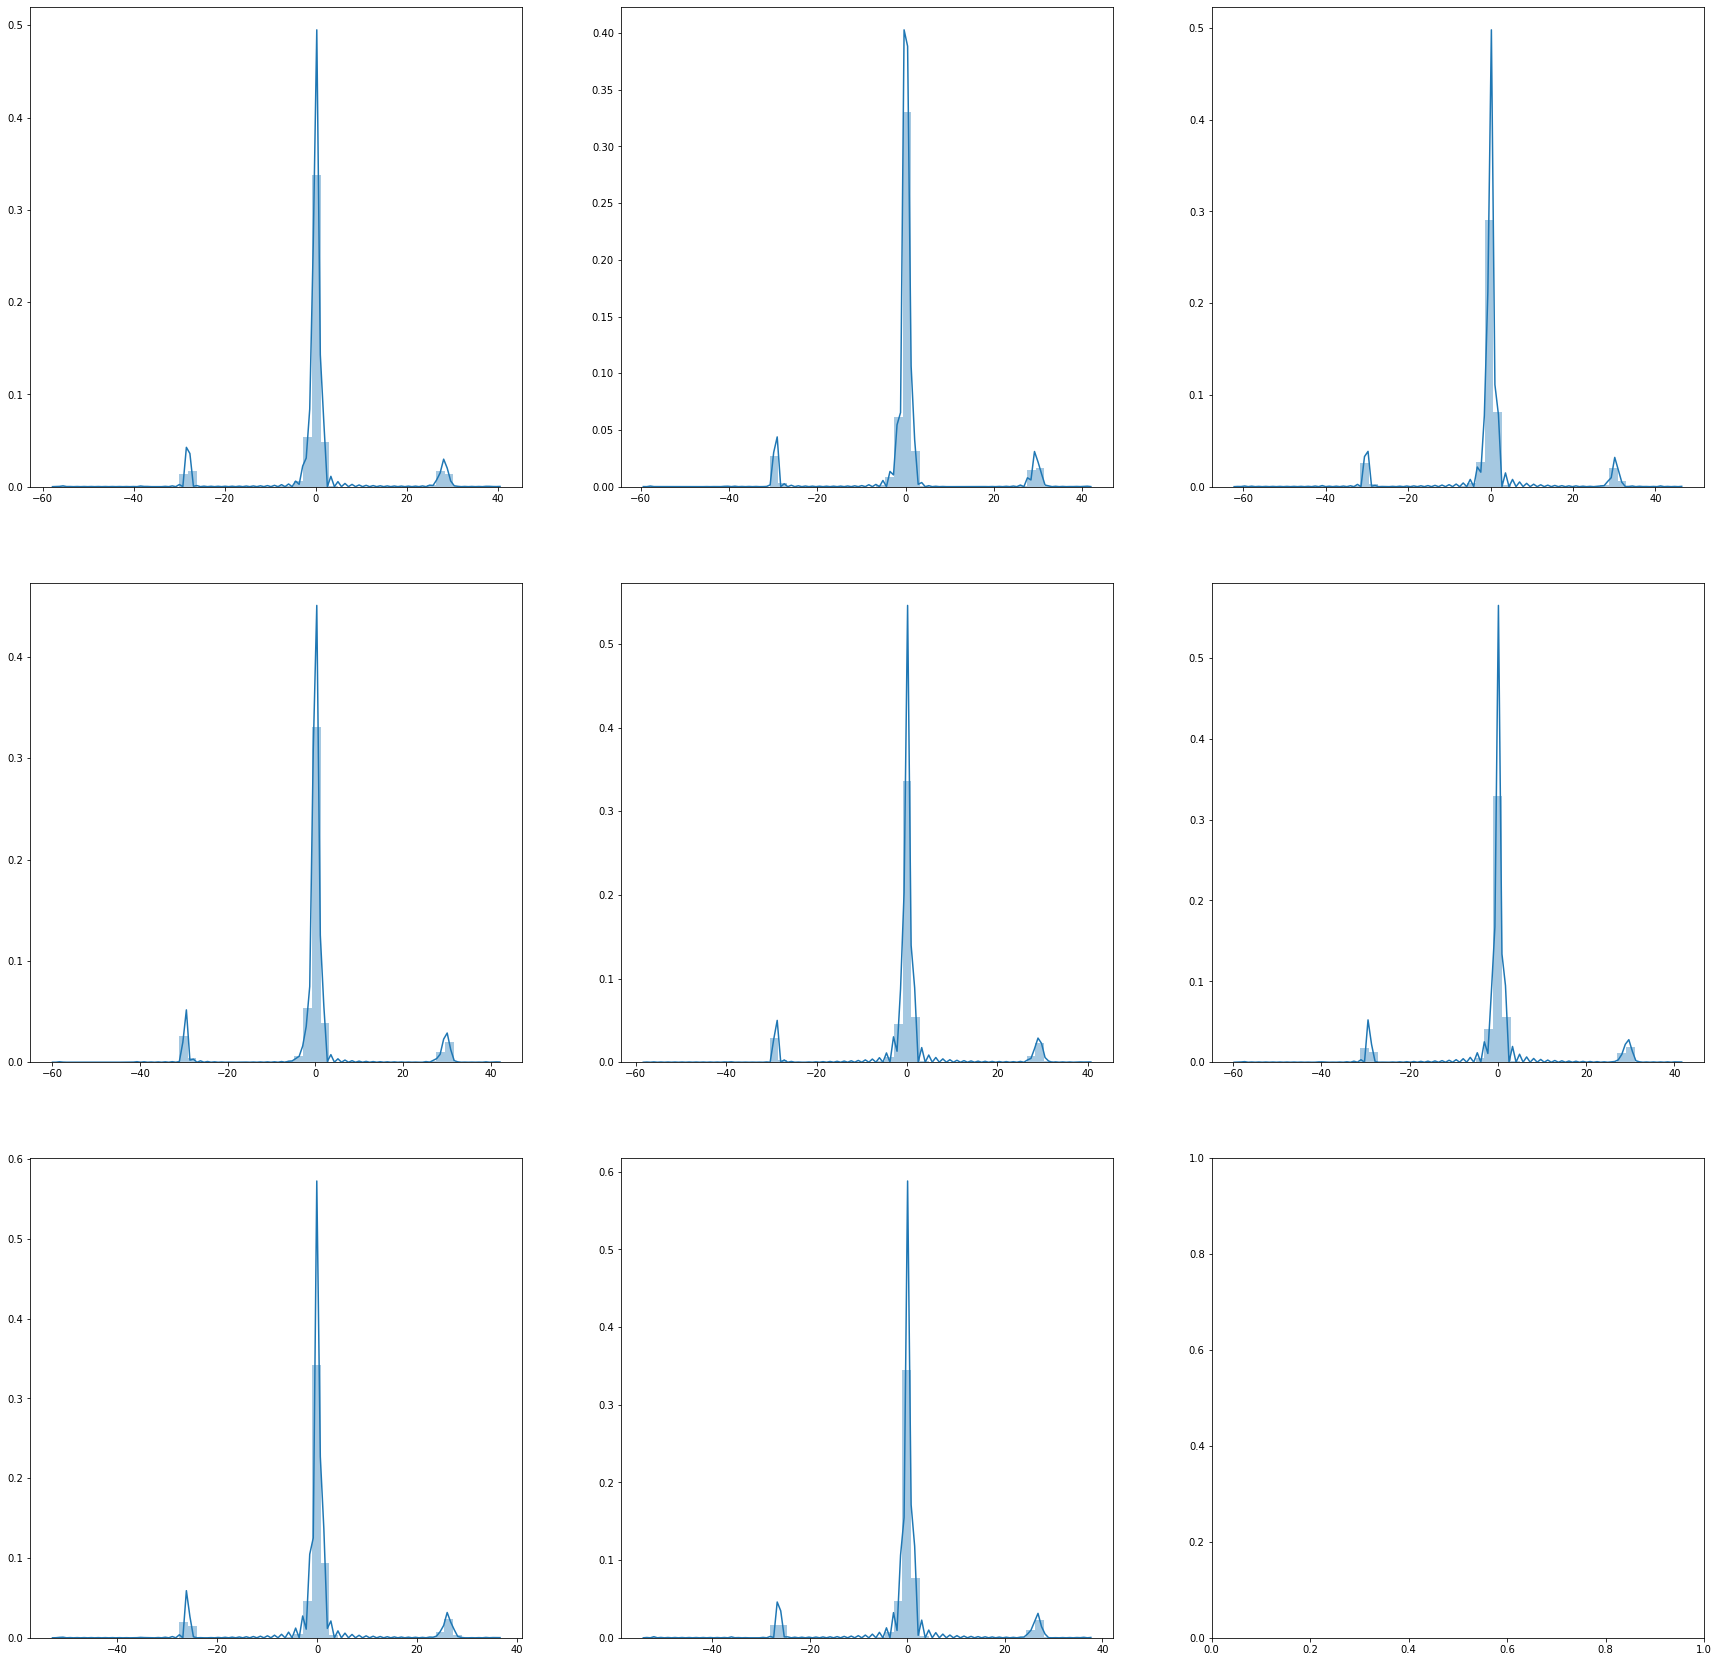

In [5]:
data = []
for i in range(6):
    data.append(residual_data[i].flatten())
    
for i in range(2):
    data.append(aged_residual_data[i].flatten())
    
data = np.array(data)

y = 3
x = 3
fig,ax = plt.subplots(y,x,figsize=(30,30))
count = 0
for i in range(y):
    for j in range(x):
        if count >= 8:
            break
        dummy = sns.distplot(data[count], ax=ax[i, j])
        count += 1
    if count >= 8:
        break

plt.show()


ほとんどのデータの残差が0なのに対して，いくつかのデータは残差が大きくなっていた．

次は残差の絶対値をとって可視化してみる．

In [6]:
def generate_residual_data(data_n, data):
    """
    測定値-推定値(周りの平均)
    残差を求めてデータ生成
    """
    tmp_x = [0, 1, 0, -1]
    tmp_y = [-1, 0, 1, 0]

    residual_data = np.zeros_like(data)

    for i in range(data_n):
        for j in range(data[i].shape[0]):
            for k in range(data[i].shape[1]):
                data_list = []
                for l in range(4):
                    next_y = j + tmp_y[l]
                    next_x = k + tmp_x[l]
                    if 0 <= next_y < 148 and 0 <= next_x < 33:
                        data_list.append(data[i, next_y, next_x])

                data_mean = mean(data_list)
                residual_data[i, j, k] = np.abs(data[i, j, k] - data_mean)

    return residual_data


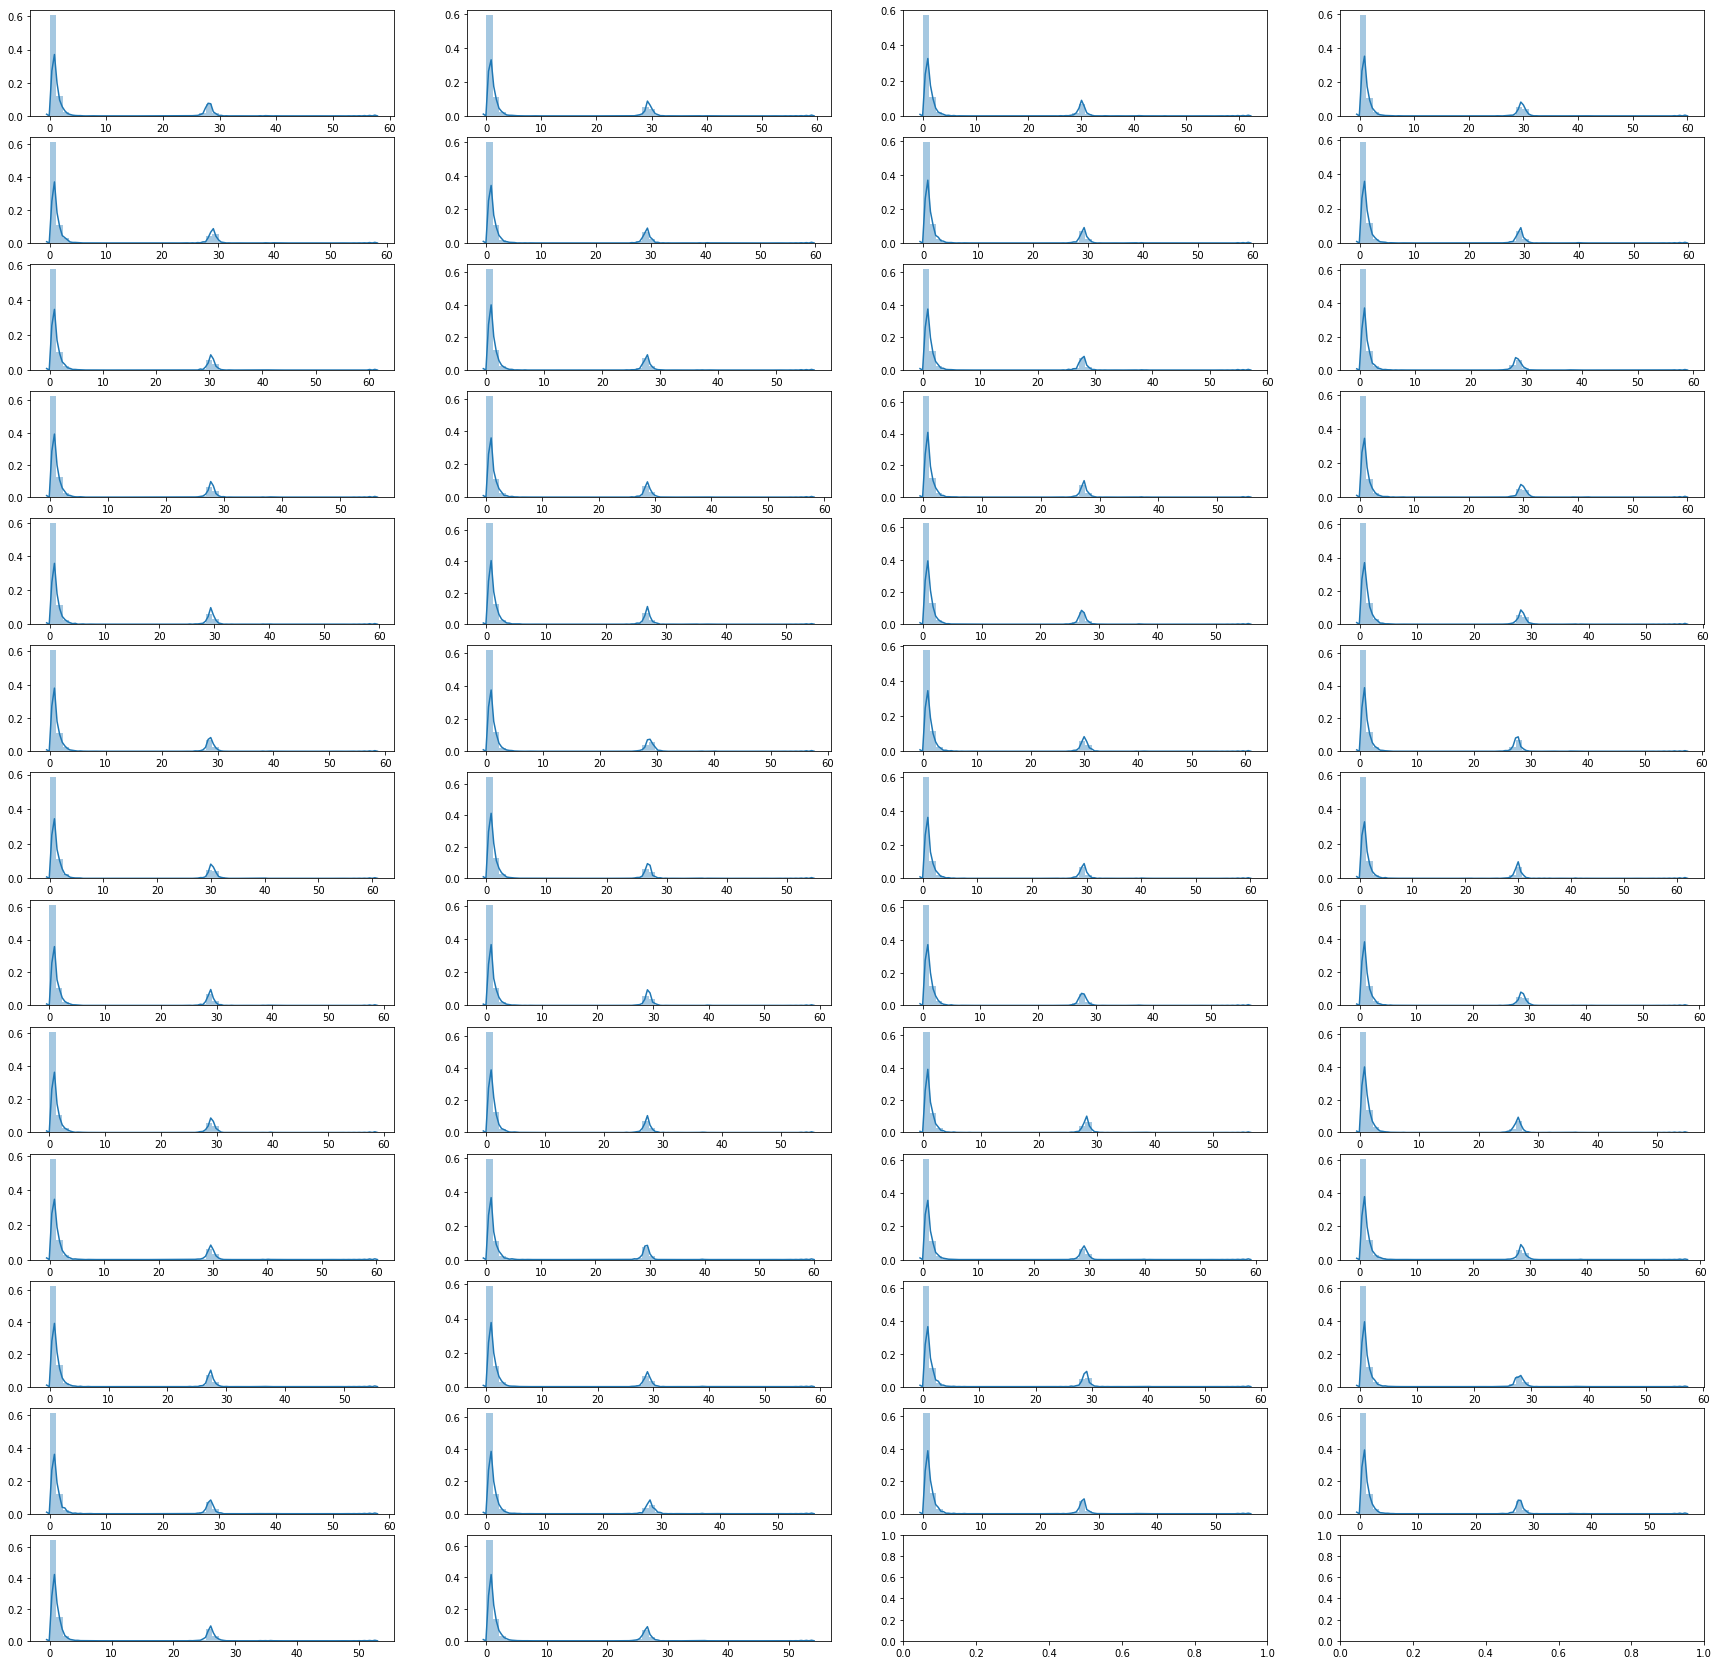

In [7]:
residual_data, aged_residual_data = generate_nnr()

data = []
for i in range(48):
    data.append(residual_data[i].flatten())
    
for i in range(2):
    data.append(aged_residual_data[i].flatten())
    
data = np.array(data)

y = 13
x = 4
fig,ax = plt.subplots(y,x,figsize=(30,30))
count = 0
for i in range(y):
    for j in range(x):
        if count >= 50:
            break
        dummy = sns.distplot(data[count], ax=ax[i, j])
        count += 1
    if count >= 50:
        break

plt.show()

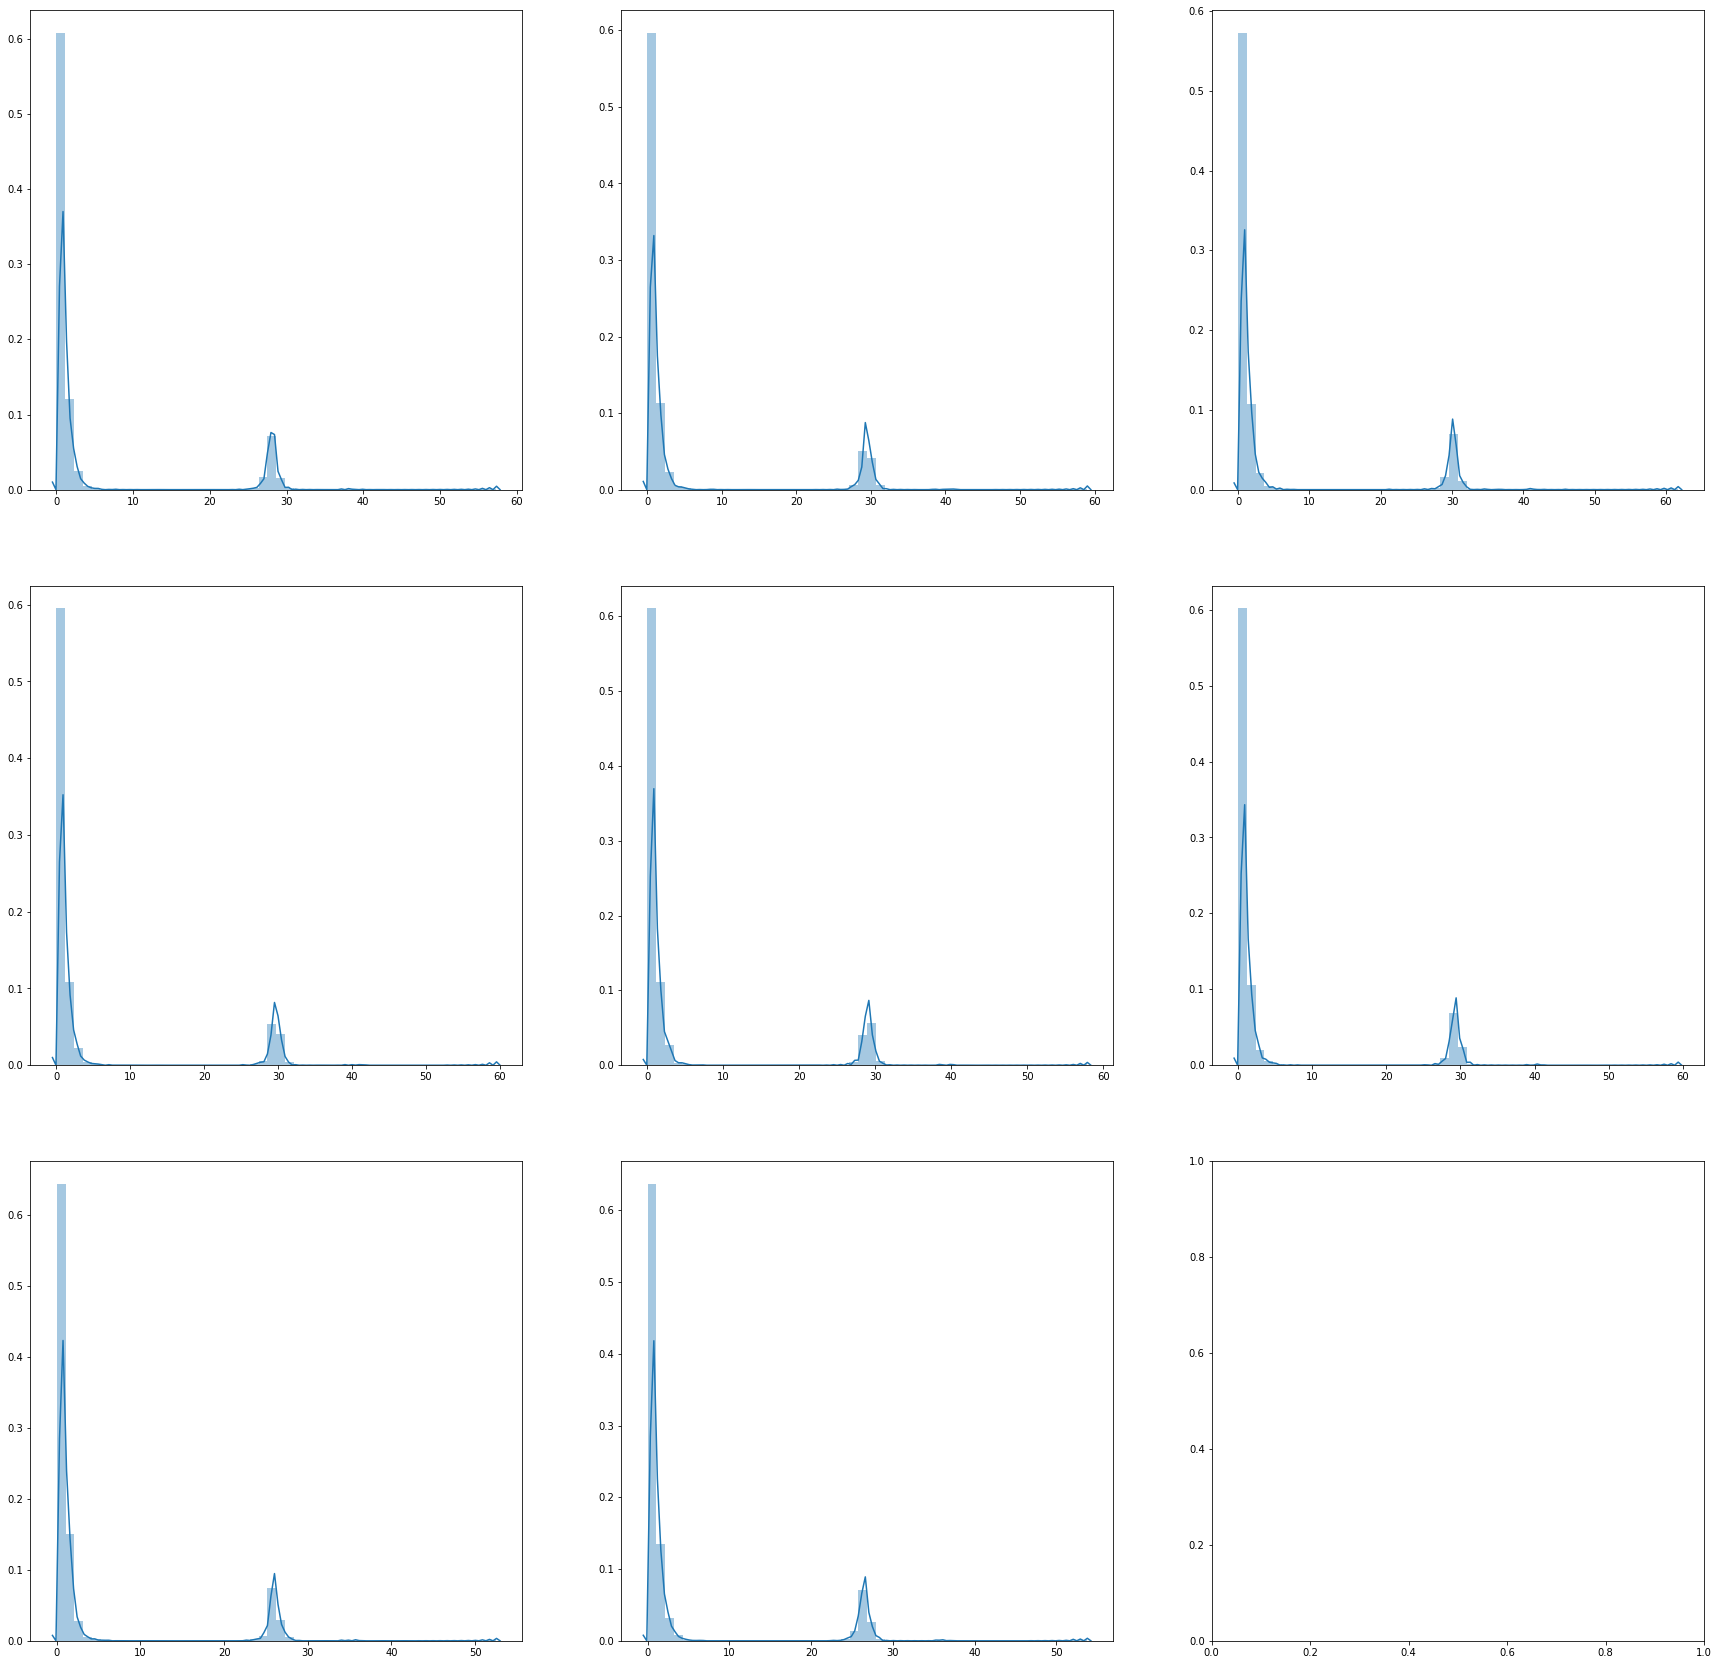

In [8]:
data = []
for i in range(6):
    data.append(residual_data[i].flatten())
    
for i in range(2):
    data.append(aged_residual_data[i].flatten())
    
data = np.array(data)

y = 3
x = 3
fig,ax = plt.subplots(y,x,figsize=(30,30))
count = 0
for i in range(y):
    for j in range(x):
        if count >= 8:
            break
        dummy = sns.distplot(data[count], ax=ax[i, j])
        count += 1
    if count >= 8:
        break

plt.show()

0から離れてる場所に密集している分布が，なんらかの異常を持っていると仮定する．

しかしこの異常は全てのFPGAに存在する．
この異常の分布に何かしらの違いがあると仮定する．

15以上の値をとる分布だけを抜き出してみる．

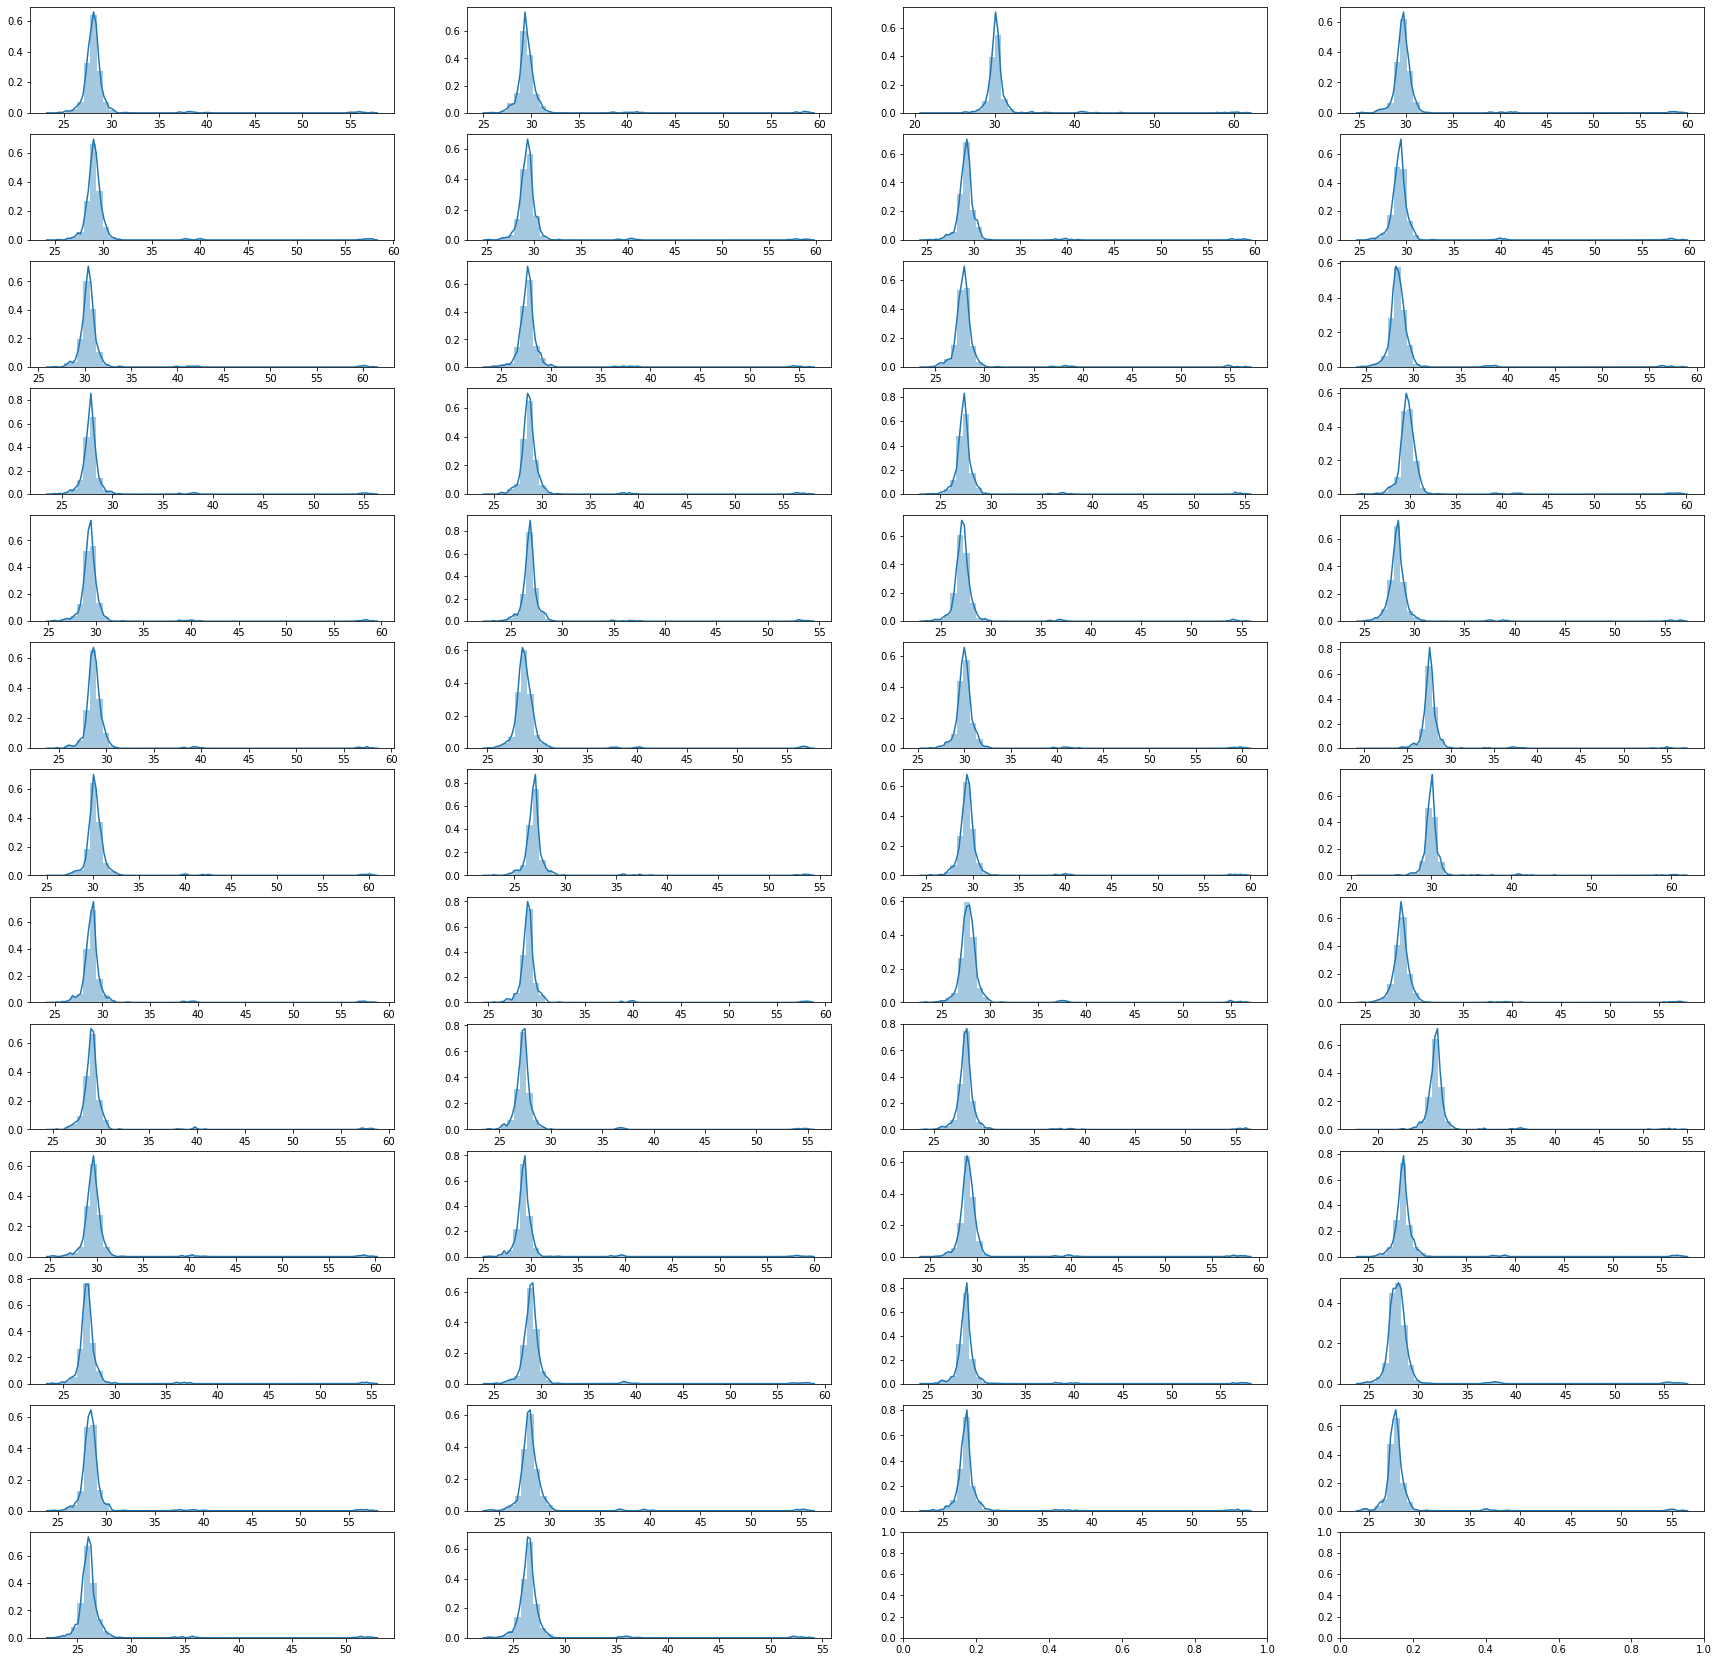

In [9]:
data = []
for i in range(48):
    data.append(residual_data[i].flatten())
    
for i in range(2):
    data.append(aged_residual_data[i].flatten())
    
data = np.array(data)


new_data = []    
for i in range(data.shape[0]):
    tmp = []
    for j in range(len(data[i])):
        if data[i, j] >= 15:
            tmp.append(data[i, j])
    new_data.append(tmp)


y = 13
x = 4
fig,ax = plt.subplots(y,x,figsize=(30,30))
count = 0
for i in range(y):
    for j in range(x):
        if count >= 50:
            break
        dummy = sns.distplot(new_data[count], ax=ax[i, j])
        count += 1
    if count >= 50:
        break

plt.show()

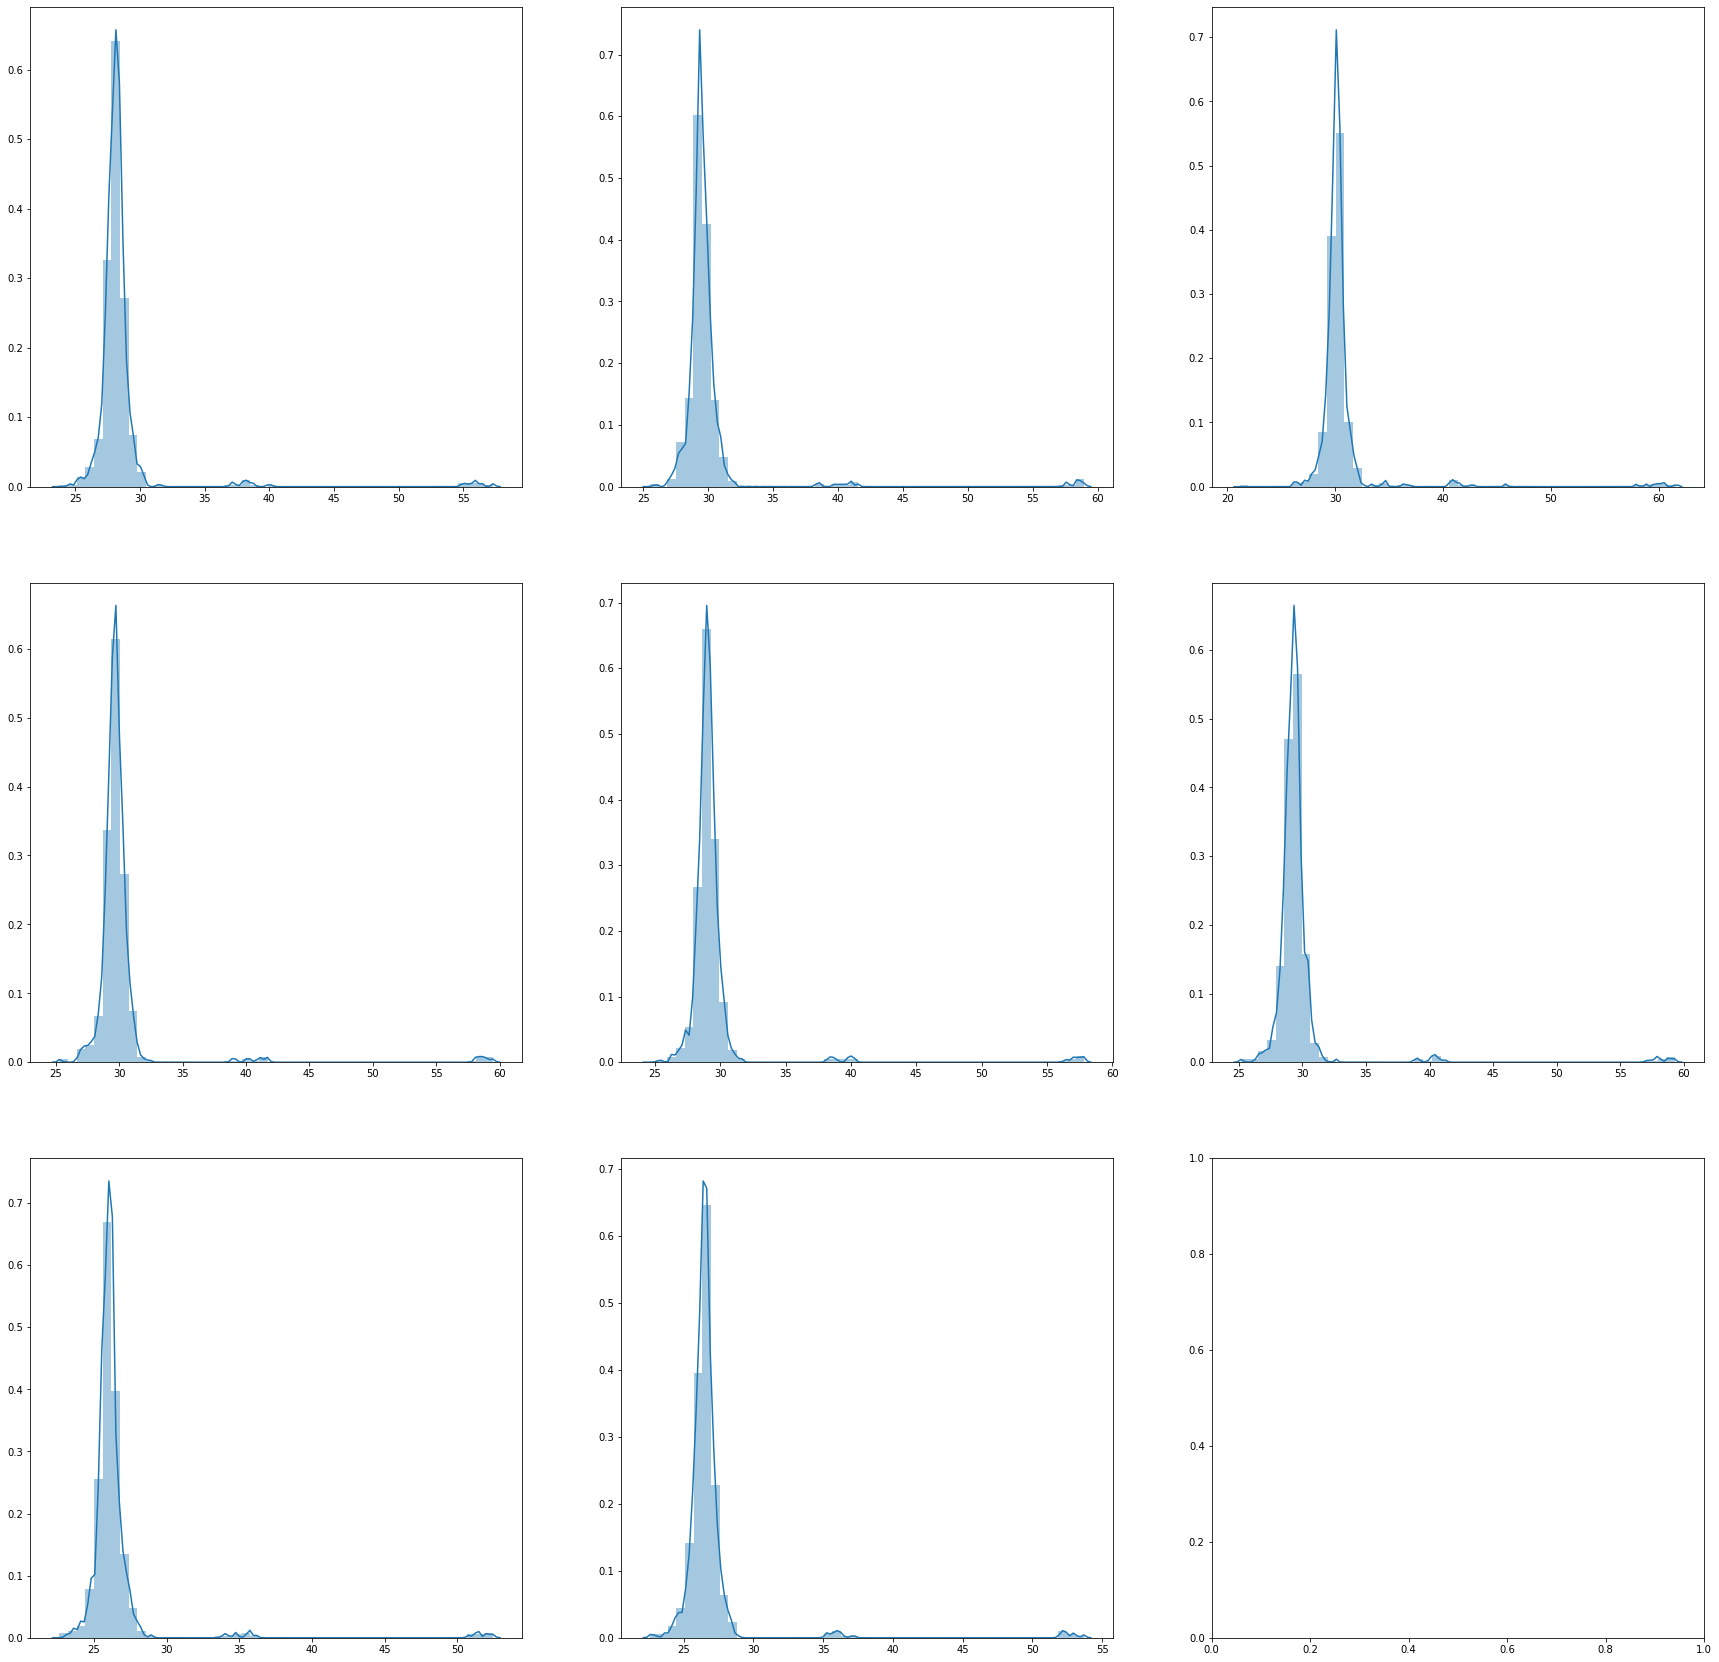

In [10]:
data = []
for i in range(6):
    data.append(residual_data[i].flatten())
    
for i in range(2):
    data.append(aged_residual_data[i].flatten())
    
data = np.array(data)

new_data = []    
for i in range(data.shape[0]):
    tmp = []
    for j in range(len(data[i])):
        if data[i, j] >= 15:
            tmp.append(data[i, j])
    new_data.append(tmp)

y = 3
x = 3
fig,ax = plt.subplots(y,x,figsize=(30,30))
count = 0
for i in range(y):
    for j in range(x):
        if count >= 8:
            break
        dummy = sns.distplot(new_data[count], ax=ax[i, j])
        count += 1
    if count >= 8:
        break

plt.show()

25-30に値が集まっていて,40や60あたりにも値が集まっていうのがわかる．

大体のばらつき具合は一緒なことがわかった．

若干経年劣化したFPGAのほうが,残差が低くなっているような気がする．

--------------------------------------------------------

この残差の合計をそれぞれのFPGAでとり,その合計値を基に異常検知をしてみる．

ここではホテリング理論を使う．

まずは合計した値を散布図で可視化する．

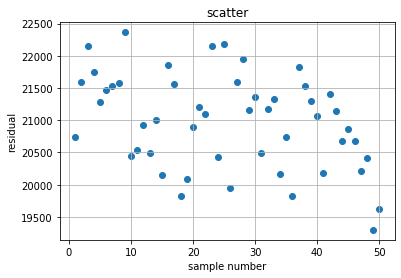

In [11]:
data = []
for i in range(48):
    data.append(residual_data[i].sum())
  
for i in range(2):
    data.append(aged_residual_data[i].sum())
  
data = np.array(data)

x = np.arange(1, 51)
plt.scatter(x, data)
plt.title("scatter")
plt.xlabel("sample number")
plt.ylabel("residual")
plt.grid(True)
plt.show()

横軸を標本番号、縦軸を合計残差として、データを可視化したもの．

これを見ると意図的に経年劣化させたFPGAの残差合計が1番小さくなっている．

次にヒストグラムにしてみる.

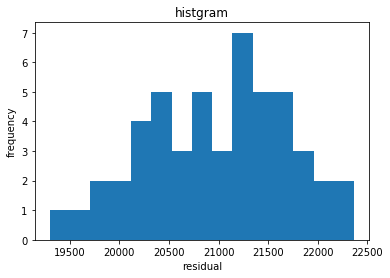

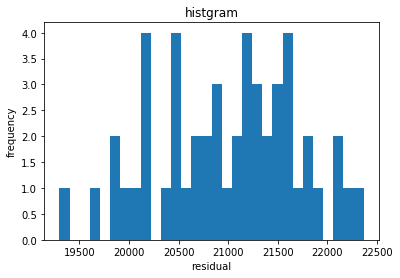

In [12]:
plt.figure()
plt.hist(data, bins=15)
plt.title("histgram")
plt.xlabel("residual")
plt.ylabel("frequency")
plt.show()

plt.figure()
plt.hist(data, bins=30)
plt.title("histgram")
plt.xlabel("residual")
plt.ylabel("frequency")
plt.show()

ビンを15と30として可視化したもの．

小さい値が二つあるが,ぱっと見わからない.

ここから異常値を見つけたい.

統計学的にせめていく.(ホテリング理論)

1. 
    1. 未知パラメータを含む確率分布を仮定
         上記のヒストグラムによると,体重データの分布は若干左右非対称だが,おおむね山の形になっている．
     
         そこで,それぞれの観測データxが平均μ,分散σの正規分布に従うと仮定する.

    2. データから未知パラメータを推定
        正規分布に含まれているパラメータは平均μ,分散σの二つ.
    
        言い換えると,この二つのパラメータを決定すると,分布の形が一意に決まるということ.
    
        これらのパラメータを観測データから推定する. パラメータ推定には最尤推定を用いる．
    
        最尤推定は,「観測データが得られる確率」をパラメータの関数とみなした尤度関数を最大化するようにパラメータを決定する推定法.
        
2. 
    学習したモデルを基に,データの異常度合いをスコアリング（異常度の定義）
    
    一般に、異常度の定義として,負の対数尤度を採用されることが多い.（これは情報理論におけるシャノン情報量と呼ばれるもの）
    
    異常度yは、
    y = (x − μ * σ) / 2
    
    という形で定義される．
    
    F統計量とも呼ばれてるいる．
    
3. 
    異常度が決まると,それに閾値を設定することで異常判定をすることができる.
    
    閾値は経験に基づき主観的に決める方法もあるが,できるだけ客観的基準に基づいて決めたい.

    ここでホテリング理論が登場
    
    ホテリング理論は観測データが正規分布に従うと仮定した元で異常検知を行う古典的手法
    
    ホテリング理論が有効な理由に，異常検知が従う確率分布を明示的に導くことができる点が挙げられる．

    これで異常度の確率分布がわかれば，それに基づいて闘値を決定することは簡単

    ホテリング理論によると異常度はデータ数Nが十分に大きい時,自由度1のカイ二乗分布に従うということが数学的に証明できるらしい
    
    
------------------------------------------------------------------------------------------------------------
    
実際にコードに書いてみる．

グラフの赤線がカイ二乗分布による5%水準の闘値（有意水準）

グラフの赤線より上を異常値と判定する．

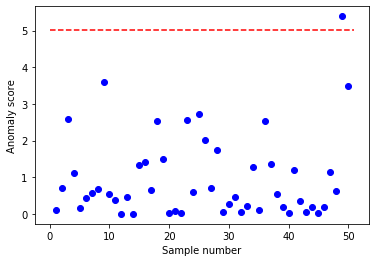

In [13]:
# 標本平均
mn = mean(data)

# 標本分散
vari = variance(data)

# 異常度
anomaly_scores = []
for x in data:
    anomaly_score = (x - mn)**2 / vari
    anomaly_scores.append(anomaly_score)

# カイ二乗分布による5%水準の閾値
threshold = stats.chi2.interval(0.95, 1)[1]

# 結果の描画
num = np.arange(1, 51)
plt.plot(num, anomaly_scores, "o", color = "b")
plt.plot([0,51],[threshold, threshold], 'k-', color = "r", ls = "dashed")
plt.xlabel("Sample number")
plt.ylabel("Anomaly score")
plt.show()

1. 正規分布を仮定したデータの最尤推定を行い，平均値と分散を推定する．
2. 全てのデータに対してF統計量を求める．

   これは自由度1のカイ二乗分布で近似できるとする.
    
3. カイ二乗分布による有意水準5%の閾値で，異常かどうか判定する．

------------------------------------------------------------

このグラフ結果を見ると，49番目の値を異常値を判定している．

実際に49番目は経年劣化させた値なので，この判定は正しい．

次に異常と判定されるのは9番目の値でその次に50番目と予想される．

まだ精度に曖昧さを感じる．

In [14]:
data = []
for i in range(48):
    data.append(mean(residual_data[i])
  
for i in range(2):
    data.append(mean(aged_residual_data[i]))
  
data = np.array(data)

x = np.arange(1, 51)
plt.scatter(x, data)
plt.title("scatter")
plt.xlabel("sample number")
plt.ylabel("residual")
plt.grid(True)
plt.show()
                
plt.figure()
plt.hist(data, bins=15)
plt.title("histgram")
plt.xlabel("residual")
plt.ylabel("frequency")
plt.show()

plt.figure()
plt.hist(data, bins=30)
plt.title("histgram")
plt.xlabel("residual")
plt.ylabel("frequency")
plt.show()
                
# 標本平均
mn = mean(data)

# 標本分散
vari = variance(data)

# 異常度
anomaly_scores = []
for x in data:
    anomaly_score = (x - mn)**2 / vari
    anomaly_scores.append(anomaly_score)

# カイ二乗分布による5%水準の閾値
threshold = stats.chi2.interval(0.95, 1)[1]

# 結果の描画
num = np.arange(1, 51)
plt.plot(num, anomaly_scores, "o", color = "b")
plt.plot([0,51],[threshold, threshold], 'k-', color = "r", ls = "dashed")
plt.xlabel("Sample number")
plt.ylabel("Anomaly score")
plt.show()

SyntaxError: invalid syntax (<ipython-input-14-05829ad147e8>, line 5)